<div class="alert alert-secondary" role="alert">
  <center> <h1> TabNet implimentation for Tabular-playground-serie </h1> </center>  
</div>


## About the Notebook  
This notebook is for the implimentation of TabNet for TPS Aug , it uses the  pyTorch implementation of Tabnet which can be found  in this [GitHub repository](http://https://github.com/dreamquark-ai/tabnet).
You can also check the origin paper [TabNet: Attentive Interpretable Tabular Learning](https://arxiv.org/pdf/1908.07442.pdf) . 
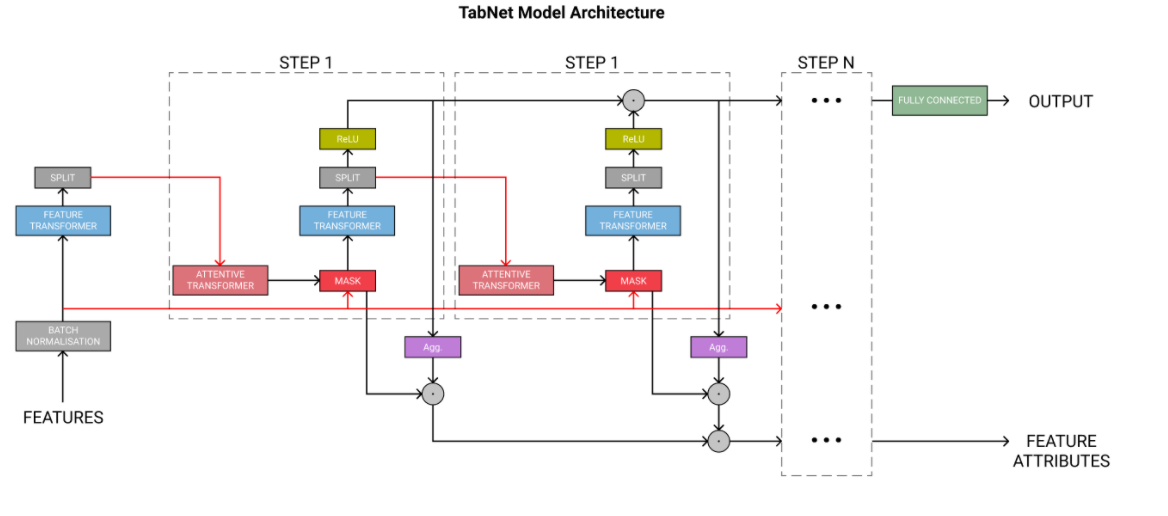


In [ ]:
### install package 
!pip install ../input/pytorchtabnet/pytorch_tabnet-3.1.1-py3-none-any.whl

In [ ]:
#importing libraries 
import os 
import torch
from math import sqrt
import pandas as pd  
import numpy  as np  
import matplotlib.pyplot as plt # ploting
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from pytorch_tabnet.tab_model import TabNetRegressor
import torch.optim as optim
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### Basic EDA to better know the data


In [ ]:
## prepare the data  
train_data = pd.read_csv('../input/tabular-playground-series-aug-2021/train.csv')
test_data = pd.read_csv('../input/tabular-playground-series-aug-2021/test.csv')
sample     = pd.read_csv('../input/tabular-playground-series-aug-2021/sample_submission.csv')

In [ ]:
#quick look at the train data
train_data.head()
train_data.tail()

In [ ]:
print(f'Number of rows: {train_data.shape[0]};  Number of columns: {train_data.shape[1]}; No of missing values: {sum(train_data.isna().sum())}')

The train dataset has 250000 of rows with 102 of columns and there is 0 missing values. we can continue.. 

In [ ]:
print('Info about train data: ')
train_data.info()

95 columns are in a float4 type while 7 are in int64 type. 

#### Basic summary statistic
basic statistics for each variables in the train data  which contain information on count, mean, standard deviation, minimum, median ,1st quartile and  3rd quartile and maximum.


In [ ]:
train_data.describe().T.style.bar().background_gradient(cmap='coolwarm')

In [ ]:
# Correlationmatrix
corrMatrix =train_data.corr(method='pearson', min_periods=1)
corrMatrix 


In [ ]:
cor_targ = train_data.corrwith(train_data["loss"])


In [ ]:
# variables variaition 
train_data.var()
#Standard  deviation  
train_data.std()

#### Target Column
The target ["loss"] for this competition  which we are predicting is is an integer value.

In [ ]:
print('loss column basic statistics:')
train_data['loss'].describe()

In [ ]:
print('percentage of each loss value:')
percent_value = pd.DataFrame(train_data['loss'].value_counts()/len(train_data))
percent_value

In [ ]:
# visualization 
countplt, ax = plt.subplots(figsize = (10,7))
ax =sns.countplot(train_data['loss'])

**Quick look at the Test dataset**

In [ ]:
test_data.head() # head 
test_data.tail() # tail

In [ ]:
print(f'Number of rows: {test_data.shape[0]};  Number of columns: {test_data.shape[1]}; No of missing values: {sum(test_data.isna().sum())}')

The test dataset has 150000 of rows with 101 of columns and there is 0 missing values. we can continue.. 

In [ ]:
print('Info about test data: ')
test_data.info()

#### Basic summary statistic for test data 
basic statistics for each variables in the test data  which contain information on count, mean, standard deviation, minimum, median ,1st quartile and  3rd quartile and maximum.


In [ ]:
test_data.describe().T.style.bar().background_gradient(cmap='coolwarm')

In [ ]:
features = train_data.iloc[:,1:101]
i = 1
plt.figure()
fig, ax = plt.subplots(8,6,figsize=(24, 24))
for feature in features:
    plt.subplot(17, 6,i)
    sns.distplot(train_data[feature],color="blue", kde=True,bins=120, label='train')
    sns.distplot(test_data[feature],color="green", kde=True,bins=120, label='test')
    plt.xlabel(feature, fontsize=9); plt.legend()
    i += 1
plt.show()

Features from train and test data have almost identical distribution...

### Basic Feature Selection 
We will try to reduce the number of features based on their variation and their correlation with the target.

**Remove features with low variance** 



In [ ]:
feat = train_data.iloc[:,1:101] 
targ=train_data["loss"]

In [ ]:
var = VarianceThreshold(threshold=0.8) #threshold of 0.8 you can try other values 
var = var.fit(feat,targ)

In [ ]:
cols = var.get_support(indices=True)
cols.shape # from 100 to 63 features , you can start from here  ...

**Remove features which are not correlated with the response variable**

In [ ]:
# correlations only with the target variable
cor_target = abs(corrMatrix['loss'])

#Select correlations with a correlation above a threshold
feat_cor = cor_target[cor_target>0.01]
feat_cor.shape # 36 feat cool ! 

**Data Normalization** 

In [ ]:
# data normalization 
X_tr =  train_data.iloc[:,1:101]
X_ts  = test_data.drop (['id'], axis=1)
norm = MinMaxScaler().fit(X_tr)

# transform training data
X_train_norm = norm.transform(X_tr)

# transform testing data
X_test_norm = norm.transform(X_ts)

In [ ]:
# converting to df 
X_train_normal = pd.DataFrame(X_train_norm)
X_train_normal.describe()
X_test_normal = pd.DataFrame(X_test_norm)
### adding loss column back 
X_train_normal["loss"] = train_data["loss"]
X_train_normal.shape

**Data standardization**

In [ ]:
# copy of datasets
X_train_stand = X_tr.copy()
X_test_stand = X_ts.copy()
num_cols = X_tr.columns
for i in num_cols:
    scale = StandardScaler().fit(X_train_stand[[i]])
    X_train_stand[i] = scale.transform(X_train_stand[[i]])
    X_test_stand[i] = scale.transform(X_test_stand[[i]])
    
# adding loss column back 
X_train_stand["loss"] = train_data["loss"]

you can use filtred features or Standarized / normalized data and see if it can improve your score 

## Tabnet Implimentation  


**Data preparation**

In [ ]:
target = 'loss'
ignore_id = 'id'
features = [ col for col in train_data.columns if col not in [ignore_id]+[target]]

In [ ]:
X = train_data[[*features]]
y= train_data["loss"]
X_test = test_data[[*features]]
print(X.shape, X_test.shape)

In [ ]:
X  = X.to_numpy()  
y = y.to_numpy().reshape(-1, 1) 
X_test = X_test.to_numpy()

In [ ]:

#y = np.log1p(train_data["loss"])


**Model Definition and Fitting**

In [ ]:
# model definition 
max_epochs = 1000
Bs = 2048 
clf = TabNetRegressor(  verbose = 0,
                       optimizer_fn=torch.optim.Adam,
                       optimizer_params=dict(lr=2e-2),
                       scheduler_params={"step_size":10, # how to use learning rate scheduler
                                         "gamma":0.9},
                       scheduler_fn=torch.optim.lr_scheduler.StepLR,
                       mask_type='sparsemax'
                           )

In [ ]:
# training ,validating and predicting 
kf = KFold(n_splits=7, random_state=42, shuffle=True)
predictions_array =[]
CV_score_array    =[]
for train_index, test_index in kf.split(X):
    X_train, X_valid = X[train_index], X[test_index]
    y_train, y_valid = y[train_index], y[test_index]
    clf.fit( 
        X_train=X_train, y_train=y_train,
        eval_set=[(X_valid, y_valid)],
        eval_metric=['rmse'],
        max_epochs=max_epochs,
        patience=50,
        batch_size=Bs, virtual_batch_size=128,
        num_workers=0,
        drop_last=False
           )
    CV_score_array.append(clf.best_cost)
    predictions_array.append(clf.predict(X_test))
predictions = np.mean(predictions_array,axis=0)

In [ ]:
print(f"BEST VALID SCORE  : {clf.best_cost}") # validation score 


**Global explainability**


In [ ]:
feat_importances = clf.feature_importances_
indices = np.argsort(feat_importances)

In [ ]:
plt.figure(figsize=(22,24))
plt.title("Feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices],
       color="darkblue", align="center")
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show()

***Creat submission***

In [ ]:
# creat submission
#predictions = pd.DataFrame(predictions) # from array to dataframe
sample['loss'] = predictions
sample.to_csv('tabnet_submission.csv',index=False)
sample




## Observations 
* This is just a baseline submission over which a lot of improvement can be made including model parameters tuning.
* There is always need for Feature Engineering and Selection so you should concentrate on that 
* Even if tabnet doesn't achive Achieve a SOTA Result in this problem , it's output is a great condidate for stacking and ensembling techniques.
* I would really appreaciate any Feedback  from you. 


**References**
* [Pytorch_tabnet](https://github.com/dreamquark-ai/tabnet)
* [TabNet on AI Platform](https://cloud.google.com/blog/products/ai-machine-learning/ml-model-tabnet-is-easy-to-use-on-cloud-ai-platform)
* [tabnet baseline ](https://www.kaggle.com/optimo/tabnet-baseline)